Data source used for data creation:

https://foodcom.pl/en/powdered-milk-how-is-it-made-and-where-is-it-usedpowdered-milk-how-is-it-made-and-where-is-it-used/

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math

%matplotlib inline

### Data

In [90]:
# Set seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 500

# Generate random data slightly around the acceptable ranges
water = np.random.uniform(2.5, 6.5, n_samples)
protein = np.random.uniform(20, 38, n_samples)
ph = np.random.uniform(5.8, 7.4, n_samples)
fat = np.random.uniform(20, 30, n_samples)

# Define acceptable ranges
acceptable = (
    (water >= 4*0.95) & (water <= 5*1.05) &
    (protein >= 24*0.95) & (protein <= 34*1.05) &
    (ph >= 6.5*0.95) & (ph <= 6.9*1.05) &
    (fat >= 26*0.95) & (fat <= 26*1.05)
)

# Create binary target: 1 = WMP, 0 = Not WMP
is_wmp = acceptable.astype(int)

# Create DataFrame
df = pd.DataFrame({
    'Water': water,
    'Protein': protein,
    'ph': ph,
    'fat':fat,
    'WMP_1': is_wmp
})

print(df.tail(10))
print("\nNumber of WMP samples:", df['WMP_1'].sum())

        Water    Protein        ph        fat  WMP_1
490  4.322627  34.389486  6.180071  27.655129      0
491  4.980530  32.504536  6.397203  21.589082      0
492  3.609525  24.898612  6.163631  26.102251      0
493  3.252485  30.624152  5.917113  21.353541      0
494  4.354794  26.497530  6.765518  27.513751      0
495  3.913409  21.648477  6.869140  26.569552      0
496  4.834624  36.511644  6.791185  29.566146      0
497  2.810939  22.462735  6.541590  20.689580      0
498  6.397579  37.104272  6.407657  20.570547      0
499  6.444843  28.028104  7.181334  22.821871      0

Number of WMP samples: 18


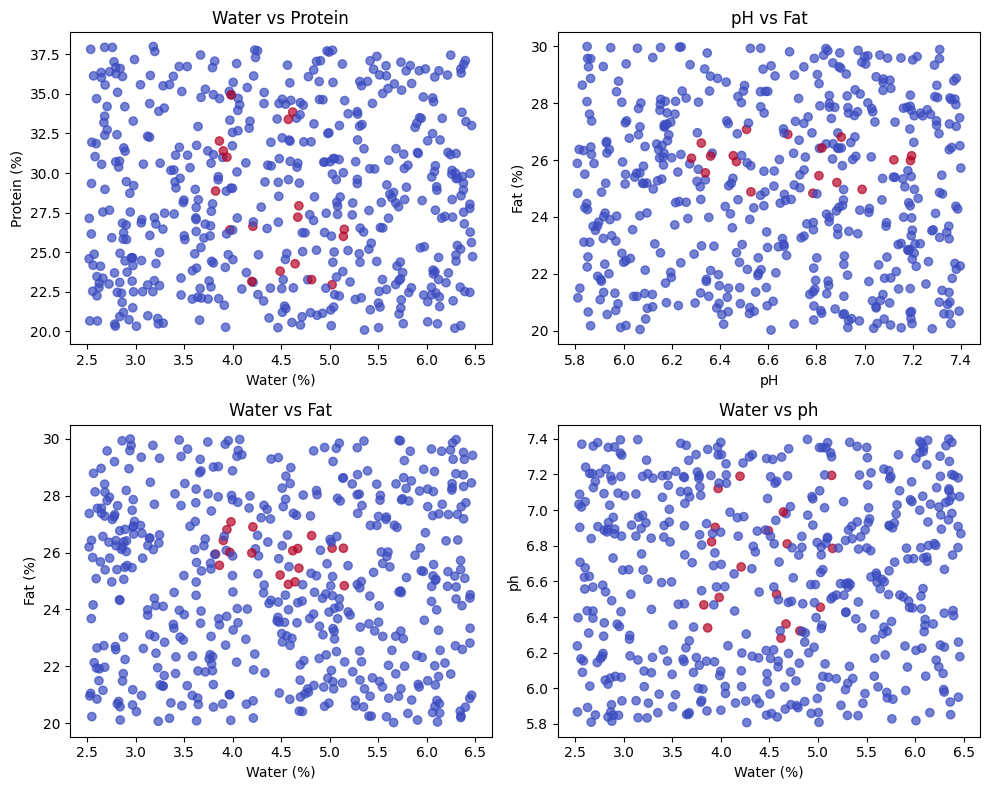

In [91]:
#Simple visualization of the data
plt.figure(figsize=(10, 8))

# Water vs Protein
plt.subplot(2, 2, 1)
plt.scatter(df['Water'], df['Protein'],
            c=df['WMP_1'], cmap='coolwarm', alpha=0.7)
plt.xlabel('Water (%)')
plt.ylabel('Protein (%)')
plt.title('Water vs Protein')

# pH vs Fat
plt.subplot(2, 2, 2)
plt.scatter(df['ph'], df['fat'],
            c=df['WMP_1'], cmap='coolwarm', alpha=0.7)
plt.xlabel('pH')
plt.ylabel('Fat (%)')
plt.title('pH vs Fat')

# Water vs Fat
plt.subplot(2, 2, 3)
plt.scatter(df['Water'], df['fat'],
            c=df['WMP_1'], cmap='coolwarm', alpha=0.7)
plt.xlabel('Water (%)')
plt.ylabel('Fat (%)')
plt.title('Water vs Fat')

# Water vs ph
plt.subplot(2, 2, 4)
plt.scatter(df['Water'], df['ph'],
            c=df['WMP_1'], cmap='coolwarm', alpha=0.7)
plt.xlabel('Water (%)')
plt.ylabel('ph')
plt.title('Water vs ph')

plt.tight_layout()
plt.show()


In [92]:
y_train = df['WMP_1']
X_train = df[['Water', 'Protein', 'ph', 'fat']]
print("First five elements in X_train are \n", X_train[:5])
print('Type of X_train: ', type(X_train))

First five elements in X_train are 
       Water    Protein        ph        fat
0  3.998160  32.566911  6.096213  25.190818
1  6.302857  29.649735  6.667042  24.791819
2  5.427976  25.571497  7.196713  20.256421
3  4.894634  34.648310  6.971560  23.412478
4  3.124075  32.325161  7.090498  23.801956
Type of X_train:  <class 'pandas.core.frame.DataFrame'>


In [93]:
print("First 5 elements in Y_train are: \n", y_train[:5])
print('Type of y_train: ', type(y_train))

First 5 elements in Y_train are: 
 0    0
1    0
2    0
3    0
4    0
Name: WMP_1, dtype: int64
Type of y_train:  <class 'pandas.core.series.Series'>


In [94]:
#Checking dimensions of the variables
print('The shape of X_train is' + str(X_train.shape))#+ ok bc str added to a str
print('The shape of y_train is' + str(y_train.shape))
print(f"We have m={len(y_train)} training exemples")

The shape of X_train is(500, 4)
The shape of y_train is(500,)
We have m=500 training exemples


### Activation function, Cost computation and Gradient Descent

In [95]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    """
    g = 1 / (1+np.exp(-z))
    return g
print ("sigmoid(0) = " + str(sigmoid(0)))

sigmoid(0) = 0.5


In [96]:
def compute_cost(X, y, w, b, lambda_= 0):
    """
    Computes the cost over all examples
    """

    m, n = X.shape
    
    cost = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb = sigmoid(z)
        cost += -y[i]*np.log(f_wb) - (1-y[i])*np.log(1-f_wb)
    total_cost = cost/m

    # Add L2 regularization term (skip bias)
    reg_cost = (lambda_ / (2 * m)) * np.sum(np.square(w))
    total_cost += reg_cost

    return total_cost
    
    return total_cost

In [97]:
def compute_gradient(X, y, w, b, lambda_=0):
    """
    Computes gradient for logistic regression.
    """
    m, n = X.shape
    dj_dw = np.zeros(n)
    dj_db = 0.

    for i in range(m):
        z = np.dot(X[i], w) + b
        f_wb = 1 / (1 + np.exp(-z))  # sigmoid
        err = f_wb - y[i]
        dj_db += err
        dj_dw += err * X[i]

    dj_db /= m
    dj_dw /= m
    
    return dj_db, dj_dw


In [98]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [ ]:
# Prepare data
X = df[['Water', 'Protein', 'ph', 'fat']].values
y = df['WMP_1'].values

# Initialize parameters
w_init = np.zeros(X.shape[1])
b_init = 0
alpha = 0.01
iterations = 1000
lambda_ = 1  # no regularization for now

# Train logistic regression
w_final, b_final, J_history, w_history = gradient_descent(
    X, y, w_init, b_init,
    compute_cost, compute_gradient,
    alpha, iterations, lambda_
)

print("\nFinal weights:", w_final)
print("Final bias:", b_final)
print("Final cost:", J_history[-1])


Iteration    0: Cost     0.25   
Iteration  100: Cost     0.16   
Iteration  200: Cost     0.16   
Iteration  300: Cost     0.16   
Iteration  400: Cost     0.16   
Iteration  500: Cost     0.16   
Iteration  600: Cost     0.16   
Iteration  700: Cost     0.16   
Iteration  800: Cost     0.16   
Iteration  900: Cost     0.16   
Iteration  999: Cost     0.16   

Final weights: [-0.07605987 -0.07454991 -0.08654969 -0.0098781 ]
Final bias: -0.017609565187954476
Final cost: 0.15627536027415567


In [111]:
def predict(X, w, b):
    """
    Predict binary labels (0 or 1) using logistic regression parameters w, b.
    Works with either pandas DataFrame or numpy array.
    """
    # Convert to numpy array if it's a DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values

    # Linear combination
    z = np.dot(X, w) + b

    # Apply sigmoid to get probabilities
    f_wb = 1 / (1 + np.exp(-z))

    # Convert probabilities to 0/1 labels
    p = (f_wb >= 0.5).astype(int)

    return p


In [112]:
# Compute accuracy on the training set
p = predict(X_train, w_final, b_final)
accuracy = np.mean(p == y_train) * 100
print(f"Train Accuracy: {accuracy:.2f}%")


Train Accuracy: 96.40%
